#  贸易战影响分析

分析公司的影响

In [1]:
import os

from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import *
os.environ["PYSPARK_PYTHON"]="/Users/sunlu/anaconda2/envs/python36/bin/python3.6" #在Mac中使用

In [2]:
spark = SparkSession\
        .builder\
        .appName("check company")\
        .getOrCreate()

In [18]:
# Loading data from a JDBC source   company_data_import  country_data_export
url = "jdbc:mysql://localhost:3306/gongdan?useUnicode=true&characterEncoding=UTF-8&user=root&password=root"
# table_name = "company_data_import"
table_name = "company_data_export"
type_i_e = table_name.split("_")[2]
if type_i_e == "import":
    type_i_e = "进口"
else:
    if type_i_e == "export":
        type_i_e = "出口"
ds = spark.read.jdbc(url=url,table=table_name)\
    .withColumn("MONTH", col("MONTH").cast("int"))

In [19]:
# print(ds.count())

In [20]:
# 公司每月向各国出口金额，金额是亿元
# company_name = "青岛中联油国际贸易有限公司" # √ import
# company_name = "青岛中集冷藏箱制造有限公司"
# company_name = "中车青岛四方机车车辆股份有限公司"
# company_name = "青岛中集集装箱制造有限公司"
company_name = "青岛乐金浪潮数字通信有限公司" # √ export
country_name = "美国"
ds1 = ds.groupBy("COMPANYNAME","TIME","YEAR","MONTH").agg({"USD": "sum", "RMB": "sum"})\
    .filter(col("COMPANYNAME") == company_name).orderBy(col("TIME").asc())\
    .withColumnRenamed("sum(RMB)","RMB").withColumnRenamed("sum(USD)","USD")

In [21]:
ds1.filter(col("TIME") == "201602").show(truncate=False)

+----------------------------+------+----+-----+------------+-----------+
|COMPANYNAME                 |TIME  |YEAR|MONTH|RMB         |USD        |
+----------------------------+------+----+-----+------------+-----------+
|青岛乐金浪潮数字通信有限公司|201602|2016|2    |2.60401871E8|3.9768291E7|
+----------------------------+------+----+-----+------------+-----------+



In [22]:
x = list(ds1.rdd.map(lambda x:x.TIME).collect())
y1 = ds1.rdd.map(lambda x:float(x.USD) /10e6).collect()
y2 = ds1.rdd.map(lambda x:float(x.RMB) / 10e6).collect()

<Figure size 720x360 with 0 Axes>

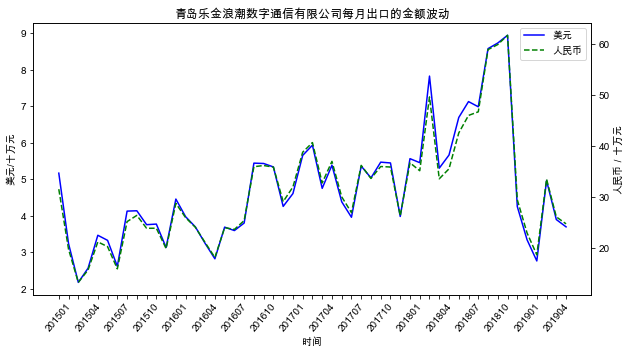

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure()

# 设置figure_size尺寸
plt.rcParams['figure.figsize'] = (10.0, 5.0)

"""
解决标题乱码
https://blog.csdn.net/qq_21904665/article/details/78732696
"""
plt.rcParams['font.sans-serif']=['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x,y1, 'b-', label = '美元')

ax2 = ax1.twinx()
ax2.plot(x,y2, 'g--', label = '人民币')

# 增加图例
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

ax1.set_title(u"%s每月%s的金额波动"  %(company_name,type_i_e))
ax1.set_xlabel("时间")
ax1.set_ylabel(r"美元/十万元")
ax2.set_ylabel(r"人民币／十万元")

# X轴倾斜
for xtick in ax1.get_xticklabels():
    xtick.set_rotation(50)

""" 
x轴标签过于密集的解决方法
https://blog.csdn.net/funnyPython/article/details/83925573
"""
for label in ax1.get_xticklabels():
    label.set_visible(False)
for label in ax1.get_xticklabels()[::3]:
    label.set_visible(True)

plt.show()
# plt.savefig("./2_3.png")

In [27]:
ds.filter(col("COMPANYNAME") == company_name)\
    .select("COMPANYNAME","COMMODITIES_TYPE")\
    .drop_duplicates().show(truncate = False)

+----------------------------+--------------------+
|COMPANYNAME                 |COMMODITIES_TYPE    |
+----------------------------+--------------------+
|青岛乐金浪潮数字通信有限公司|电器及电子产品      |
|青岛乐金浪潮数字通信有限公司|塑料制品            |
|青岛乐金浪潮数字通信有限公司|仪器仪表            |
|青岛乐金浪潮数字通信有限公司|纺织纱线、织物及制品|
+----------------------------+--------------------+



In [28]:
# Window function
w1 = Window.partitionBy('COMPANYNAME')

ds.filter(col("COMPANYNAME") == company_name)\
    .groupBy("COMPANYNAME","COMMODITIES_TYPE").agg({"USD": "sum", "RMB": "sum"})\
    .withColumn("sum_USD",sum("sum(USD)").over(w1))\
    .withColumn("sum_RMB",sum("sum(RMB)").over(w1))\
    .withColumn("percent", bround(col("sum(USD)") / col("sum_USD"), 3))\
    .select("COMPANYNAME","COMMODITIES_TYPE","sum(USD)","percent")\
    .drop_duplicates().show(truncate = False)

+----------------------------+--------------------+-------------+-------+
|COMPANYNAME                 |COMMODITIES_TYPE    |sum(USD)     |percent|
+----------------------------+--------------------+-------------+-------+
|青岛乐金浪潮数字通信有限公司|电器及电子产品      |2.511514894E9|1.0    |
|青岛乐金浪潮数字通信有限公司|塑料制品            |9239.0       |0.0    |
|青岛乐金浪潮数字通信有限公司|仪器仪表            |70349.0      |0.0    |
|青岛乐金浪潮数字通信有限公司|纺织纱线、织物及制品|10838.0      |0.0    |
+----------------------------+--------------------+-------------+-------+



## 2.4 企业进口、出口国家分析

###  1）进口

公司：青岛渤海农业发展有限公司

进口国家：美国、巴西

COMMODITIES_TYPE：粮食

2019年美国下降、巴西上升




In [116]:
# Loading data from a JDBC source   company_data_import  country_data_export
url = "jdbc:mysql://localhost:3306/gongdan?useUnicode=true&characterEncoding=UTF-8&user=root&password=root"
table_name = "company_data_import"
# table_name = "company_data_export"
type_i_e = table_name.split("_")[2]
if type_i_e == "import":
    type_i_e = "进口"
else:
    if type_i_e == "export":
        type_i_e = "出口"
ds = spark.read.jdbc(url=url,table=table_name)\
    .withColumn("MONTH", col("MONTH").cast("int"))

In [117]:
country_name = "美国" # import √
# country_name = "巴西" # import √

company_name = "青岛渤海农业发展有限公司" # import √

ds2 = ds.filter(col("COMPANYNAME") == company_name)\
    .filter(col("COUNTRY") == country_name)

In [107]:
ds.filter(col("COMMODITIES_TYPE") == "原油")\
    .select("COMPANYNAME","COUNTRY","COMMODITIES_TYPE").drop_duplicates().show(truncate = False)

+--------------------------------+----------+----------------+
|COMPANYNAME                     |COUNTRY   |COMMODITIES_TYPE|
+--------------------------------+----------+----------------+
|青岛中联油进出口有限公司        |澳大利亚  |原油            |
|青岛青保投资控股有限公司        |越南      |原油            |
|青岛中联油国际贸易有限公司      |哥伦比亚  |原油            |
|青岛中港仓储有限公司            |阿曼      |原油            |
|青岛中联油进出口有限公司        |刚果(金)  |原油            |
|青岛青保投资控股有限公司        |安哥拉    |原油            |
|青岛港超能国际物流有限公司      |阿联酋    |原油            |
|青岛中联油国际贸易有限公司      |刚果(布)  |原油            |
|中国石化青岛石油化工有限责任公司|巴西      |原油            |
|青岛邦达吉通国际物流有限公司    |巴西      |原油            |
|青岛中联油国际贸易有限公司      |阿尔及利亚|原油            |
|青岛中联油国际贸易有限公司      |加蓬      |原油            |
|青岛港超能国际物流有限公司      |马来西亚  |原油            |
|青岛中联油国际贸易有限公司      |利比亚    |原油            |
|青岛中联油国际贸易有限公司      |阿联酋    |原油            |
|中国石化青岛石油化工有限责任公司|赤道几内亚|原油            |
|青岛中联油国际贸易有限公司      |巴西      |原油            |
|青岛中联油国际贸易有限公司      |俄罗斯联邦|原油            |
|青岛中

In [200]:
x = list(ds2.rdd.map(lambda x:x.TIME).collect())
y1 = ds2.rdd.map(lambda x:float(x.USD) / 10e6).collect()
y2 = ds2.rdd.map(lambda x:float(x.RMB) / 10e6).collect()

<Figure size 720x360 with 0 Axes>

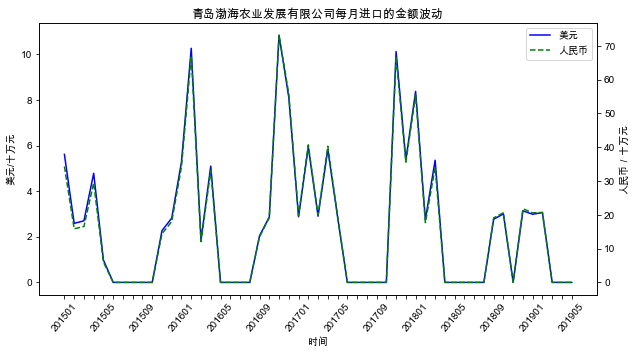

In [201]:
import matplotlib.pyplot as plt
fig = plt.figure()

# 设置figure_size尺寸
plt.rcParams['figure.figsize'] = (10.0, 5.0)

"""
解决标题乱码
https://blog.csdn.net/qq_21904665/article/details/78732696
"""
plt.rcParams['font.sans-serif']=['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x,y1, 'b-', label = '美元')

ax2 = ax1.twinx()
ax2.plot(x,y2, 'g--', label = '人民币')

# 增加图例
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

ax1.set_title(u"%s每月%s的金额波动"  %(company_name,type_i_e))
ax1.set_xlabel("时间")
ax1.set_ylabel(r"美元/十万元")
ax2.set_ylabel(r"人民币／十万元")

# X轴倾斜
for xtick in ax1.get_xticklabels():
    xtick.set_rotation(50)

""" 
x轴标签过于密集的解决方法
https://blog.csdn.net/funnyPython/article/details/83925573
"""
for label in ax1.get_xticklabels():
    label.set_visible(False)
for label in ax1.get_xticklabels()[::4]:
    label.set_visible(True)

plt.show()
# plt.savefig("./2_3.png")

In [87]:
ds.select(col("COMPANYNAME") == "青岛港董家口矿石码头有限公司").select("COMPANYNAME","COUNTRY")

In [187]:
ds.filter(col("COMPANYNAME") == "中国石化青岛石油化工有限责任公司").filter(col("YEAR") == "2019")\
    .select("COMPANYNAME","COUNTRY","COMMODITIES_TYPE","YEAR").drop_duplicates().show(truncate = False)

+--------------------------------+--------+----------------+----+
|COMPANYNAME                     |COUNTRY |COMMODITIES_TYPE|YEAR|
+--------------------------------+--------+----------------+----+
|中国石化青岛石油化工有限责任公司|科威特  |原油            |2019|
|中国石化青岛石油化工有限责任公司|巴西    |原油            |2019|
|中国石化青岛石油化工有限责任公司|刚果(布)|原油            |2019|
+--------------------------------+--------+----------------+----+



###  2）出口

In [32]:
# Loading data from a JDBC source   company_data_import  country_data_export
url = "jdbc:mysql://localhost:3306/gongdan?useUnicode=true&characterEncoding=UTF-8&user=root&password=root"
# table_name = "company_data_import"
table_name = "company_data_export"
type_i_e = table_name.split("_")[2]
if type_i_e == "import":
    type_i_e = "进口"
else:
    if type_i_e == "export":
        type_i_e = "出口"
ds = spark.read.jdbc(url=url,table=table_name)\
    .withColumn("MONTH", col("MONTH").cast("int"))

In [55]:
# country_name = "美国" # export 
country_name = "意大利" # export 韩国 巴西
 
company_name = "青岛乐金浪潮数字通信有限公司" # export 
# company_name = "青岛一达通企业服务有限公司"
# company_name = "山东新华锦国际商务集团有限公司" # 上升 塑料制品
# company_name = "山东新华锦国际商务集团有限公司" # 上升 陶瓷产品

ds3 = ds.groupBy("COMPANYNAME","COUNTRY","TIME","YEAR","MONTH")\
    .agg({"USD": "sum", "RMB": "sum"})\
    .orderBy(col("TIME").asc())\
    .withColumnRenamed("sum(RMB)","RMB").withColumnRenamed("sum(USD)","USD")\
    .filter(col("COMPANYNAME") == company_name)\
    .filter(col("COUNTRY") == country_name)

In [56]:
ds3.filter(col("TIME") == "201901").show()

+----------------------------+-------+------+----+-----+---------+--------+
|                 COMPANYNAME|COUNTRY|  TIME|YEAR|MONTH|      RMB|     USD|
+----------------------------+-------+------+----+-----+---------+--------+
|青岛乐金浪潮数字通信有限公司| 意大利|201901|2019|    1|3577457.0|519458.0|
+----------------------------+-------+------+----+-----+---------+--------+



In [58]:
x = list(ds3.rdd.map(lambda x:x.TIME).collect())
y1 = ds3.rdd.map(lambda x:float(x.USD) / 10e6).collect()
y2 = ds3.rdd.map(lambda x:float(x.RMB) / 10e6).collect()

<Figure size 720x360 with 0 Axes>

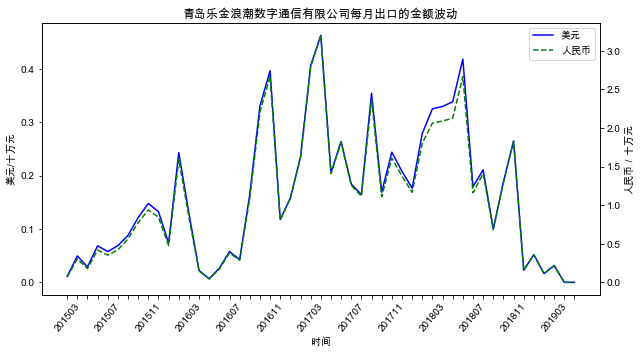

In [59]:
import matplotlib.pyplot as plt
fig = plt.figure()

# 设置figure_size尺寸
plt.rcParams['figure.figsize'] = (10.0, 5.0)

"""
解决标题乱码
https://blog.csdn.net/qq_21904665/article/details/78732696
"""
plt.rcParams['font.sans-serif']=['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x,y1, 'b-', label = '美元')

ax2 = ax1.twinx()
ax2.plot(x,y2, 'g--', label = '人民币')

# 增加图例
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

ax1.set_title(u"%s每月%s的金额波动"  %(company_name,type_i_e))
ax1.set_xlabel("时间")
ax1.set_ylabel(r"美元/十万元")
ax2.set_ylabel(r"人民币／十万元")

# X轴倾斜
for xtick in ax1.get_xticklabels():
    xtick.set_rotation(50)

""" 
x轴标签过于密集的解决方法
https://blog.csdn.net/funnyPython/article/details/83925573
"""
for label in ax1.get_xticklabels():
    label.set_visible(False)
for label in ax1.get_xticklabels()[::4]:
    label.set_visible(True)

plt.show()
# plt.savefig("./2_3.png")

进口数据分析：

美国、巴西在一张图上展示波动

In [223]:
ds3.filter(col("TIME") == "201710").show()

+--------------------+----------------------------+-------+------+----+-----+----------+-----------------+-------+----------+-----------+-------+-----------+
|    COMMODITIES_TYPE|                 COMPANYNAME|COUNTRY|  TIME|YEAR|MONTH|       USD|    ANALYSIS_TIME|ANALYST|DELETE_TAG|DELETE_TIME|REMARKS|        RMB|
+--------------------+----------------------------+-------+------+----+-----+----------+-----------------+-------+----------+-----------+-------+-----------+
|            仪器仪表|青岛乐金浪潮数字通信有限公司|   韩国|201710|2017|   10|       0.0|20190702 15:00:00|   null|      null|       null|   null|        0.0|
|            塑料制品|青岛乐金浪潮数字通信有限公司|   韩国|201710|2017|   10|    2544.0|20190702 15:00:00|   null|      null|       null|   null|    16707.0|
|      电器及电子产品|青岛乐金浪潮数字通信有限公司|   韩国|201710|2017|   10|16742846.0|20190702 15:00:00|   null|      null|       null|   null|109950272.0|
|纺织纱线、织物及制品|青岛乐金浪潮数字通信有限公司|   韩国|201710|2017|   10|       0.0|20190702 15:00:00|   null|      null|       null|   n

In [91]:
ds_test = ds.filter(col("COMPANYNAME") == "青岛乐金浪潮数字通信有限公司")\
    .groupBy("COMPANYNAME","COUNTRY","TIME")\
    .agg({"USD": "sum", "RMB": "sum"})#.show(truncate=False)
ds_test.filter(col("COUNTRY") != "美国").orderBy(col("sum(USD)").desc()).show(truncate=False)

+----------------------------+-------+------+------------+-----------+
|COMPANYNAME                 |COUNTRY|TIME  |sum(RMB)    |sum(USD)   |
+----------------------------+-------+------+------------+-----------+
|青岛乐金浪潮数字通信有限公司|韩国   |201803|1.96581945E8|3.0990352E7|
|青岛乐金浪潮数字通信有限公司|韩国   |201809|1.08484092E8|1.5773551E7|
|青岛乐金浪潮数字通信有限公司|韩国   |201802|9.4665138E7 |1.4703127E7|
|青岛乐金浪潮数字通信有限公司|韩国   |201801|8.7084817E7 |1.3181489E7|
|青岛乐金浪潮数字通信有限公司|韩国   |201808|7.9788984E7 |1.1938533E7|
|青岛乐金浪潮数字通信有限公司|韩国   |201810|7.7685098E7 |1.131984E7 |
|青岛乐金浪潮数字通信有限公司|韩国   |201804|7.0450581E7 |1.1112719E7|
|青岛乐金浪潮数字通信有限公司|韩国   |201811|7.4149016E7 |1.0743918E7|
|青岛乐金浪潮数字通信有限公司|韩国   |201902|7.0660625E7 |1.040159E7 |
|青岛乐金浪潮数字通信有限公司|韩国   |201807|5.7720608E7 |8937018.0  |
|青岛乐金浪潮数字通信有限公司|韩国   |201903|6.0353343E7 |8932607.0  |
|青岛乐金浪潮数字通信有限公司|巴西   |201803|5.32641E7   |8391376.0  |
|青岛乐金浪潮数字通信有限公司|韩国   |201812|5.5636187E7 |8017458.0  |
|青岛乐金浪潮数字通信有限公司|日本   |201811|5.4172745E7 |7870478.0  |
|青岛乐金浪潮数字通信有限公司|巴

In [92]:
import pandas as pd
import numpy as np
# pandas.DataFrame 转换成 spark.DataFrame
pandas_df = ds_test.filter(col("COUNTRY") != "美国")\
    .filter(col("COUNTRY") != "韩国")\
    .toPandas()
pandas_df2 = pd.pivot_table(pandas_df, values = 'sum(USD)', 
                            # index = ['COMPANYNAME','TIME'],
                            index = ['TIME'],
                            columns = 'COUNTRY', aggfunc=np.sum)

In [93]:
# print(pandas_df2)
print(pandas_df2.columns)
col_name = pandas_df2.columns

Index(['乌克兰', '乌兹别克斯坦', '乌拉圭', '以色列', '伊拉克', '俄罗斯联邦', '刚果(布)', '刚果(金)', '加拿大',
       '加纳', '匈牙利', '南非', '卡塔尔', '印度尼西亚', '古巴', '台澎金马关税区', '哈萨克斯坦', '哥伦比亚',
       '土耳其', '埃及', '塞内加尔', '墨西哥', '多哥', '奥地利', '尼日利亚', '巴拉圭', '巴林', '巴西',
       '布基纳法索', '希腊', '德国', '意大利', '拉脱维亚', '捷克', '新加坡', '日本', '智利', '格鲁吉亚',
       '毛里求斯', '沙特阿拉伯', '法国', '波兰', '泰国', '津巴布韦', '澳大利亚', '瑞典', '秘鲁', '立陶宛',
       '约旦', '罗马尼亚', '苏丹', '英国', '荷兰', '莫桑比克', '菲律宾', '葡萄牙', '蒙古', '西班牙',
       '赞比亚', '越南', '阿塞拜疆', '阿尔及利亚', '阿根廷', '阿联酋', '香港', '马拉维', '马里', '黎巴嫩'],
      dtype='object', name='COUNTRY')


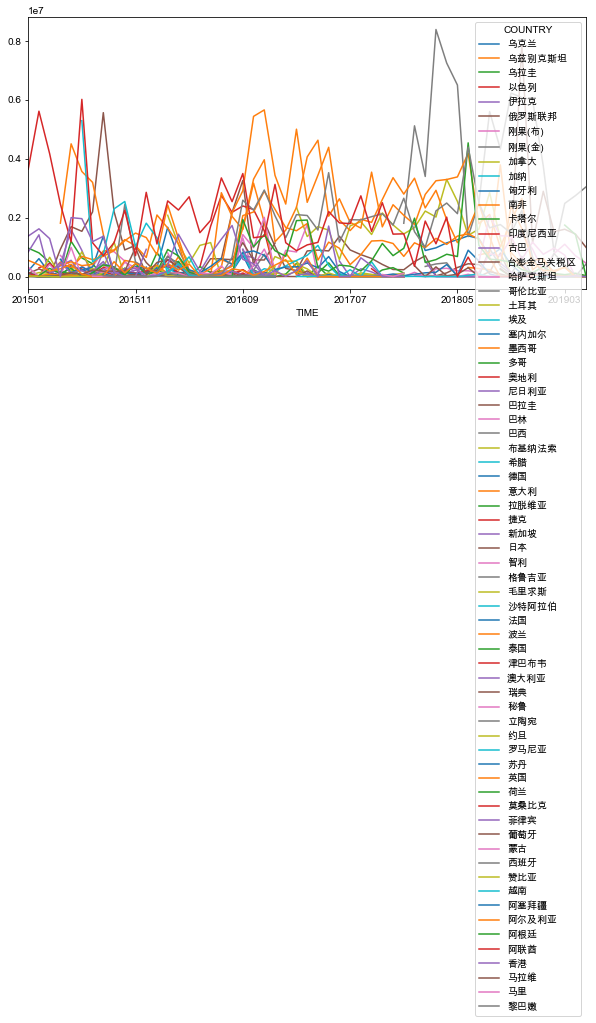

In [94]:
pandas_df2.plot(y = col_name )
plt.show()

进口数据分析：

美国、巴西在一张图上展示波动

In [ ]:
# Loading data from a JDBC source   company_data_import  country_data_export
url = "jdbc:mysql://localhost:3306/gongdan?useUnicode=true&characterEncoding=UTF-8&user=root&password=root"
table_name = "company_data_import"
# table_name = "company_data_export"
type_i_e = table_name.split("_")[2]
if type_i_e == "import":
    type_i_e = "进口"
else:
    if type_i_e == "export":
        type_i_e = "出口"
ds = spark.read.jdbc(url=url,table=table_name)\
    .withColumn("MONTH", col("MONTH").cast("int"))

In [124]:
# 使用进口数据
company_name = '青岛渤海农业发展有限公司'
ds_test2 = ds.filter(col("COMPANYNAME") == company_name)\
    .filter((col("COUNTRY") == "美国") |(col("COUNTRY") == "巴西")).groupBy('TIME')\
                .pivot('COUNTRY', ['美国','巴西'])\
                .agg({"USD": "sum", "RMB": "sum"})\
    .fillna(0)\
    .orderBy(col("TIME").asc()).toDF("TIME","m_rmb","m_usd","b_rmb","b_usd")#.show(300,truncate=False)
ds_test2.show(300,truncate=False)

+------+------------+------------+------------+------------+
|TIME  |m_rmb       |m_usd       |b_rmb       |b_usd       |
+------+------------+------------+------------+------------+
|201501|3.43137373E8|5.6125962E7 |0.0         |0.0         |
|201502|1.58588788E8|2.5884429E7 |0.0         |0.0         |
|201503|1.65471782E8|2.7007853E7 |0.0         |0.0         |
|201504|2.94501324E8|4.7842858E7 |1.77606818E8|2.895919E7  |
|201505|6.0043175E7 |9788593.0   |3.51014591E8|5.7224468E7 |
|201506|0.0         |0.0         |1.67740154E8|2.7442145E7 |
|201507|0.0         |0.0         |3.25203182E8|5.3174272E7 |
|201508|0.0         |0.0         |3.34934673E8|5.4770841E7 |
|201509|0.0         |0.0         |5.02178579E8|7.856967E7  |
|201510|0.0         |0.0         |0.0         |0.0         |
|201511|1.43921596E8|2.2666642E7 |0.0         |0.0         |
|201512|1.79891703E8|2.8197939E7 |0.0         |0.0         |
|201601|3.42468618E8|5.2866753E7 |0.0         |0.0         |
|201602|6.70805911E8|1.0

In [127]:
x = list(ds_test2.rdd.map(lambda x:x.TIME).collect())
ym_1 = ds_test2.rdd.map(lambda x:float(x.m_usd) / 10e6).collect()
ym_2 = ds_test2.rdd.map(lambda x:float(x.m_rmb) / 10e6).collect()
yb_1 = ds_test2.rdd.map(lambda x:float(x.b_usd) / 10e6).collect()
yb_2 = ds_test2.rdd.map(lambda x:float(x.b_rmb) / 10e6).collect()

<Figure size 720x360 with 0 Axes>

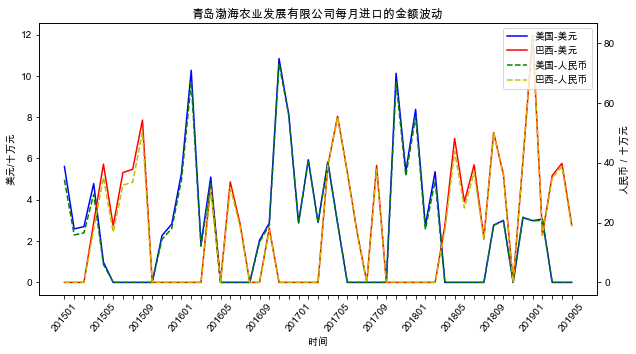

In [132]:
import matplotlib.pyplot as plt
fig = plt.figure()

# 设置figure_size尺寸
plt.rcParams['figure.figsize'] = (10.0, 5.0)

"""
解决标题乱码
https://blog.csdn.net/qq_21904665/article/details/78732696
"""
plt.rcParams['font.sans-serif']=['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x,ym_1, 'b-', label = '美国-美元')
ax1.plot(x,yb_1, 'r-', label = '巴西-美元')

ax2 = ax1.twinx()
ax2.plot(x,ym_2, 'g--', label = '美国-人民币')
ax2.plot(x,yb_2, 'y--', label = '巴西-人民币')

# 增加图例
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

ax1.set_title(u"%s每月%s的金额波动"  %(company_name,type_i_e))
ax1.set_xlabel("时间")
ax1.set_ylabel(r"美元/十万元")
ax2.set_ylabel(r"人民币／十万元")

# X轴倾斜
for xtick in ax1.get_xticklabels():
    xtick.set_rotation(50)

""" 
x轴标签过于密集的解决方法
https://blog.csdn.net/funnyPython/article/details/83925573
"""
for label in ax1.get_xticklabels():
    label.set_visible(False)
for label in ax1.get_xticklabels()[::4]:
    label.set_visible(True)

plt.show()
# plt.savefig("./2_3.png")